In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.fftpack import fft
import scipy.signal as ss
import networkx as nx
import numpy as np
import time



<center><h1> Next Step Implementation </h1></center>

In [2]:
# Next Step implementation CTD-22
def next_step(probability_array):
    i = 0                          

    p = probability_array[0]             
    r = np.random.random()

    while (r > p):
        i+=1 
        p += probability_array[i]
    return i


<center><h1> Generator </h1></center>

In [3]:
def generator(numbers_of_nodes, pattern_length, iterations, probability_array):    
    frequency_data = []
    automata_data = []
    
    # Interacao 
    for i in range(iterations):
        automata_data_buffer = []
        for i in range(pattern_length):
            buffer_data = next_step(probability_array)
            automata_data_buffer.append(buffer_data)
        automata_data.append(automata_data_buffer)
    
    
    return np.array(automata_data)
    

<center><h1> Plotting Functions </h1> </center>

In [4]:
# Plotting functions


def stem_plot(array):
    x = np.linspace(0.1, len(array), len(array))
    
    plt.stem(x, array, use_line_collection=True)
    plt.grid()
    plt.show()
    
def square_wave_plot(array):                          
    x = np.linspace(1, len(array), len(array))
    plt.grid()
    plt.plot(x, array[0], color="black")
    
def bar_plot(array):
    x = np.linspace(0.1, len(array), len(array))
    ax = plt.axes()
    # Setting the background color
    ax.set_facecolor("blue")
    
    plt.bar(x, array, color="yellow")
    

def density_plot(frequency_data):
    frequency_data = np.array(frequency_data)
    frequency_data.flatten()
    
    
    plt.plot(frequency_data)
    plt.savefig("casa.png")

<center><h1> Data treatment </h1></center>

In [5]:
# DATA ANALYSIS 

def frequency_analysis(numbers_of_nodes, array):    
#     frequency_data = np.bincount(automata_data)
    frequency_data = []
    
    for i in range(numbers_of_nodes):
        contador = 0
        
        for j in range(len(array)):
            if (array[j] == i):
                contador +=1
                
        frequency_data.append(contador)
    
    output = []
    for i in range(len(frequency_data)):
        output.append(frequency_data[i] / len(array))
    return output


# DATA ANALYSIS 
def frequency_split(array, number_of_nodes):
    split_frequency = []
    for i in range(number_of_nodes):
        buffer = []
        for j in range(len(array[0])):
            if (array[0][j] == i):
                buffer.append(1)
            else:
                buffer.append(0)
        split_frequency.append(buffer)

    return split_frequency

def entropy_of_array(array):
    return entropy(array)

def evenness_of_array(array):
    return np.exp(entropy_of_array(array))


<center><h2> Burst-Based Features </h2></center>

In [6]:
# SEGUNDO PROJETO 


# Burst-Based Futures # 1/5
def scan_bursts(L, M):
    i = 1
    Ls = []
    
    M -= 1 # Como o array começa do zero, tem que arrancar uma unidade
    L = np.array(L[0])

    while (i <= M):
        if (L[i] == 1): # Burst detected
            i0 = 1
            
            while (L[i] == 1 and i < M):
                i+=1
            
            if (i == M and L[i] == 1):
                i = M + 1

            bs = i - i0

            if (bs > 0):
                Ls.append(bs)
        i+=1
    return np.array(Ls)
    


<center><h2> Scan InterSymbols </h2></center>


In [7]:
# Scan Inter Symbols          # 2/5
def scan_inter_symbols(L, M):
    i = 1
    Ls = []

    L = np.array(L)
    L = L[0]
    M -= 1
    
    while (i < M): # Scan Signal
        if (L[i] == 1): # Possible intersymb, detected, scan it
            i0 = 1
            i += 1
            bs = 0

            while(L[i] == 0 and i < M):
                i += 1
                
            if (i == M and L[i] == 1):
                bs = M - i0
            if (i < M and L[i] == 1):
                bs = i - i0
            if (bs > 0):
                Ls.append(bs)
                i -=1
        i+=1

    return np.array(Ls)
            


<h1><center>Detrended Fluctuation Analysis (DFA)</h1></center> 

In [8]:

def calc_rms(x, scale):
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])

    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    
    for e, sc in enumerate(scales):
        fluct[e] = np.sqrt(np.mean(calc_rms(y, sc)**2))
        
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    
    if show:
        fluctfit = 2**np.polyval(coeff,np.log2(scales))
        plt.loglog(scales, fluct, 'bo')
        plt.loglog(scales, fluctfit, 'r', label=r'$\alpha$ = %0.2f'%coeff[0])
        plt.title('DFA')
        plt.xlabel(r'$\log_{10}$(time window)')
        plt.ylabel(r'$\log_{10}$<F(t)>')
        plt.legend()
        plt.show()
    return scales, fluct, coeff[0]

def dfa_manager(array):
    array = np.abs(ss.hilbert(array))
    scales, fluct, alpha = dfa(array, show=1)
#     print("\nDFA\n")
#     print("Scales: {}".format(scales))
#     print("Fluctuations: {}" .format(fluct))
#     print("DFA exponent: {}".format(alpha))

    return alpha



<center><h1> Fourier Transformation </h1></center>

In [9]:
def fourier_transformation(L):
    return fft(L[0])


<center><h1> Grafos </h1></center>

In [10]:
def visibility(L, M):
    L = L[0]
    A = np.zeros((M, M))
    for j in range(2, M):
        for i in range(1, j - 1):
            flag = 1
            k = i + 1
            visibility
            while (k<= j - 1 and flag == 1):
                aux = L[j] + (L[i] - L[j]) * (j - k) / (j - i)
                if (L[k] >= aux):
                    flag = 0

                k+=1
            
            if (flag == 1):
                A[i][j] = 1
                A[j][i] = 1

    return A


def graph_analysis(M):
    return nx.from_numpy_matrix(M)

<center><h1> Main </h1></center>

In [11]:
def main(numbers_of_nodes, pattern_length, probability_array):
    
    print("----------------------------------------------------")
    print("\nProbability Array: {}".format(probability_array))
    
    
    # Generator 
    automata_data = generator(numbers_of_nodes, pattern_length, 1, probability_array)
    
    split_frequency = frequency_split(automata_data, numbers_of_nodes)
    
#     #Burst
    print("\n\tBurst")
    burst_analysis = scan_bursts(split_frequency, pattern_length) # TODO: Por enquanto vai ser só com essa frequencia
    
    print("Mean: {}" .format(burst_analysis.mean()))
    print("Std: {}".format(burst_analysis.std()))
    print("Entropy: {}".format(entropy_of_array(burst_analysis)))
    print("Evenness: {}".format(evenness_of_array(burst_analysis)))
    
    # InterSymbols
    print("\n\tInterSymbols")
    intersymbols_analysis = scan_inter_symbols(split_frequency, pattern_length)
    
    print("Mean: {}" .format(intersymbols_analysis.mean()))
    print("Std: {}".format(intersymbols_analysis.std()))
    print("Entropy: {}".format(entropy_of_array(intersymbols_analysis)))
    print("Evenness: {}".format(evenness_of_array(intersymbols_analysis)))
    
    # Grafos
    print("\n\t Graph")
    G = graph_analysis(visibility(split_frequency, pattern_length))
    
    
    print("Mean: {}" .format(np.array(nx.degree(G)).mean()))
    print("Std: {}".format(np.array(nx.degree(G)).std()))
    print("Clustering coefficient: {}".format(nx.average_clustering(G)))

    
    # DFA
    print("\n\tDFA")
    dfa_analysis = dfa_manager(split_frequency)
    print("Alpha Value: {}".format(dfa_analysis))



<center><h1> Projeto 2</h1></center>

<p> Os automatos que serão usados para a realização das analises terão as caracteristicas descritas abaixo:</p>

<ul>
    <li> <b>(0.1, 0.9)</b> </li>
    <li> <b>(0.2, 0.8)</b> </li>
    <li> <b>(0.5, 0.5)</b> </li>
</ul>
    
    
<p> Já os métodos para a analise são: </p>

<ul>
    <li> Burst Scan </li>
    <li> Scan InterSymbol </li>
    <li> Fourier </li>
    <li> Graph Analysis </li>
    <li> DFA </li>
</ul>
    


----------------------------------------------------

Probability Array: [0.1, 0.9]

	Burst
Mean: 1255.868932038835
Std: 719.8620939301501
Entropy: 5.1377335896876275
Evenness: 170.3292944631143

	InterSymbols
Mean: 1237.5168067226891
Std: 720.9786807672577
Entropy: 5.275896818565254
Evenness: 195.5657849175275

	 Graph
Mean: 626.47
Std: 805.3600347049759
Clustering coefficient: 0.7554293041249178

	DFA


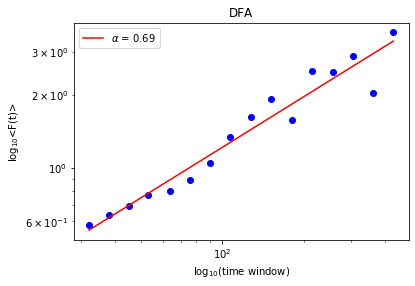

Alpha Value: 0.6910473440154371
----------------------------------------------------

Probability Array: [0.2, 0.8]

	Burst
Mean: 1286.7099236641222
Std: 740.6264024584658
Entropy: 5.779003255768792
Evenness: 323.4366460856987

	InterSymbols
Mean: 1283.6133056133056
Std: 726.2124768180194
Entropy: 5.989019339997452
Evenness: 399.0231119892806

	 Graph
Mean: 626.2052
Std: 805.5561913938469
Clustering coefficient: 0.5484575808032681

	DFA


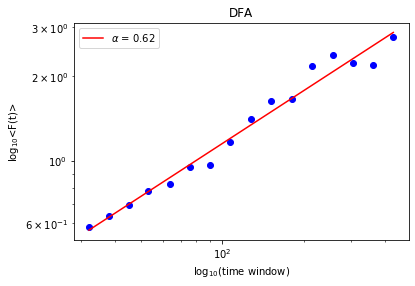

Alpha Value: 0.6244193716496672
----------------------------------------------------

Probability Array: [0.5, 0.5]

	Burst
Mean: 1237.650159744409
Std: 714.5172596606814
Entropy: 6.247753191428073
Evenness: 516.8502555377215

	InterSymbols
Mean: 1268.2986167615948
Std: 718.8642449099594
Entropy: 6.928564056771018
Evenness: 1021.0267899685499

	 Graph
Mean: 625.5132
Std: 806.0877497057998
Clustering coefficient: 0.15744249084249082

	DFA


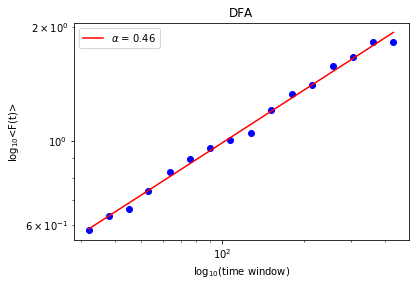

Alpha Value: 0.45927025054494447
Done!


In [12]:
if __name__ == "__main__":

    pattern_length = 2500
    
    probability_matrix = [
        [0.1, 0.9],
        [0.2, 0.8],
        [0.5, 0.5]
    ]
    
    for i in range(len(probability_matrix)):
        main(len(probability_matrix[i]), pattern_length, probability_matrix[i])
        
        
    print("Done!")